In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import io
import itertools
import time
from IPython.display import clear_output

from sklearn.decomposition import PCA
import scipy

import torch
import torch.optim as optim
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F
import torch.distributions as TD
from torchvision.utils import make_grid
from torchvision import transforms

import pickle
import os
import sys
sys.path.append('../../homeworks') # to grab dgm_utils from ../../homeworks directory
from tqdm.notebook import tqdm
from scipy.stats import multivariate_normal


# for IWAE
from scipy.stats import multivariate_normal
from matplotlib import ticker, cm
from matplotlib import gridspec
from matplotlib import collections  as mplc
from scipy.special import logsumexp
# end for IWAE

if torch.cuda.is_available():
    DEVICE = 'cuda'
    GPU_DEVICE = 2
    torch.cuda.set_device(GPU_DEVICE)
else:
    DEVICE='cpu'
# DEVICE='cpu'

import warnings
warnings.filterwarnings('ignore')

# <span style="color:red"> No! </span>

# dgm_utils
from dgm_utils import train_model, plot_training_curves, show_samples
from dgm_utils import visualize_2d_samples, visualize_2d_densities, visualize_2d_data
from seminar5_utils import visualize_2d_map, visualize_samples_pdf

# <center>Deep Generative Models</center>
## <center>Seminar 5</center>

<center><img src="pics/mipt_logo.png" width=600 /></center>
<center>08.11.2022</center>


## Plan

1. Flows intro
    
    - pushforward transform
    
    - change of variable theorem

2. Planar flow example 
    
    - computing jacobian of arbitrary map via pytorch
    
    - matrix determinant lemma

3. Normalizing flows. Forward KL and Reverse KL

4. Training Planar flow via Forward KL and Reverse KL
    

## Flows

<center><img src="pics/flowsg.png" width=800 /></center>

* $A = \mathbb{R}^D$, $p_A$ is the source distribution.

* $B = \mathbb{R}^D$, $p_B$ is the target distribution

* $g(\cdot, \theta) : \mathbb{R}^D \rightarrow \mathbb{R}^D$ is a Diffeomorphism [wiki](https://en.wikipedia.org/wiki/Diffeomorphism)

* Define $f := g^{-1}$. $g = f^{-1}$. $f$ or $g$ could be **unknown**!

**Question**

Can a function $h: \mathbb{R}^D \rightarrow \mathbb{R}^d$, $d \neq D$ be continuous, injective?

### Pushforward transform

$\mathcal{P}_B$ is the distribution of $g(x_A), x_A \sim \mathcal{P}_{A}$. I.e. $\mathcal{P}_{B}(Q) \overset{\text{def.}}{=} \mathcal{P}_{A}(f(Q))$, where $Q$ is a Borel subset of $B$

$\mathcal{P}_B$ is also called **pushforward** of $\mathcal{P}_A$ under $g$:

$$\mathcal{P}_B = g\sharp \mathcal{P}_A$$

**Question**

Is the measure $\mathcal{P}_A$ a pushforward transform of $\mathcal{P}_B$ under some mapping? What is the mapping?

$\mathcal{P}_A = f \sharp \mathcal{P}_B$

### Sampling

<center><img src="pics/flowsg.png" width=800 /></center>

**Question**

How to get samples from $\mathcal{P}_B$ given $g$ and $\boldsymbol{X}_A \sim \mathcal{P}_A$?

How to get samples from $\mathcal{P}_A$ given $f$ and $\boldsymbol{X}_B \sim \mathcal{P}_B$?

$g(\boldsymbol{X}_A) \sim \mathcal{P}_B$

$f(\boldsymbol{X}_B) \sim \mathcal{P}_A$

### pdf estimation

<center><img src="pics/flowsg.png" width=800 /></center>

### Change of variable theorem

Let $p_A(x)$ is the pdf of $\mathcal{P}_{A}$. Then 
$$
    p_A(x_A) = p_{B}(g(x_A))  \left\vert \det \left(\frac{\partial g(x, \theta)}{\partial x}\Big{|}_{x = x_A} \right) \right\vert
$$

**Equivalent formulations**:

$$
    p_A(x_A) = \frac{p_B(g(x_A))}{\left\vert \det \left(\frac{\partial f(x, \theta)}{\partial x}\Big{|}_{x = g(x_A)} \right) \right\vert}
$$

$$
    p_B(x_B) = p_A(f(x_B)) \left\vert \det \left(\frac{\partial f(x, \theta)}{\partial x}\Big{|}_{x = x_B} \right) \right\vert
$$

$$
    p_B(x_B) = \frac{p_A(f(x_B))}{\left\vert \det \left(\frac{\partial g(x, \theta)}{\partial x}\Big{|}_{x = f(x_B)} \right) \right\vert}
$$

**Question.**

What if $g = g_{K} \circ g_{K-1} \circ \dots \circ g_{1}$?

$p_A(x_A) = p_B(g(x_A)) \left\vert \det \left(\frac{\partial g_1(x, \theta)}{\partial x}\Big{|}_{x = x_A} \right) \right\vert \cdot \left\vert \det \left(\frac{\partial g_2(x, \theta)}{\partial x}\Big{|}_{x = g_1(x_A)} \right) \right\vert \cdot \dots \cdot \left\vert \det \left(\frac{\partial g_K(x, \theta)}{\partial x}\Big{|}_{x = g_{K-1} \circ \dots \circ g_1(x_A)} \right) \right\vert$

### Planar flow

$g(x_A) = x_A + \mathbf{u}h(\mathbf{w}^T x_A + b)$


$\theta = \{\mathbf{u,w} \in \mathbb{R}^D, b \in \mathbb{R}\}$

In [3]:
w = torch.tensor([5., 0.])
u = torch.tensor([1., 0.])
b = 0.

def h(x):
    return torch.tanh(x)

def g(x, w=w, u=u, b=b):
    # x : (*size, 2)
    adj = h(x @ w + b) # (*size,)
    return x + torch.kron(adj.unsqueeze(-1), u) # (*size, 2)

Samples from $p_A$

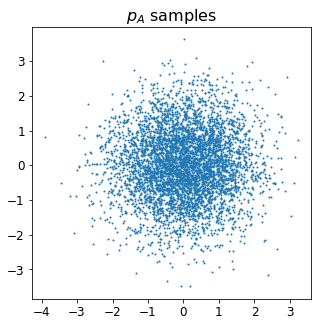

In [4]:
p_A = TD.Normal(torch.tensor([0., 0]), torch.tensor([1., 1.]))
X_A = p_A.sample((5000,))
visualize_2d_samples(X_A, r'$p_A$ samples')

Samples from $p_B$, $p_B = g\sharp p_A$

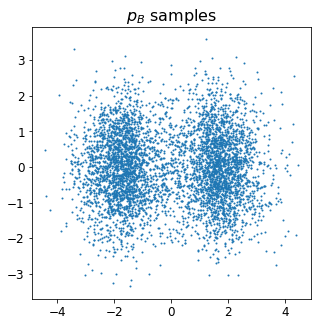

In [4]:
X_B = g(X_A)
visualize_2d_samples(X_B, r'$p_B$ samples')

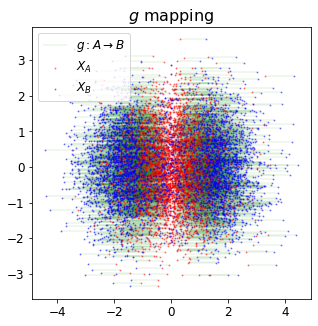

In [12]:
visualize_2d_map(
    X_A, X_B, '$g$ mapping', 
    data_label=r'$X_A$', 
    mapped_data_label=r'$X_B$', 
    map_label=r'$g: A \rightarrow B$')

**Question**

Let $x_B \in \mathbb{R}^D$. What we need to estimate $p_B(x_B)$?

* We need to be sure that the function $g$ is invertible <span style="color:orange"> Stay tuned. Will be considered soon </span>

* We need to know $x_A = f(x_B)$! <span style="color:red"> In general, unsolvable </span>

* We need to calculate $p_A(x_A)$ <span style="color:green"> Easy, as $p_A \sim \mathcal{N}(0, I)$ </span>

* We have to compute $\det \left(\frac{\partial g(x, \theta)}{\partial x}\Big{|}_{x = x_A} \right)$ <span style="color:orange"> Stay tuned. Will be considered soon </span>

### Computation of $det J_g$. Straightforward approach

In [6]:
from seminar6_utils import batch_jacobian

X_A.requires_grad_()
X_B = g(X_A)
gjacs_X_A_autograd = batch_jacobian(X_A, X_B) # (bs, 2, 2)

log_det_gjacs_X_A_autograd = torch.logdet(gjacs_X_A_autograd) # (bs, )

p_B_X_B_autograd = torch.exp(p_A.log_prob(X_A).sum(-1) - log_det_gjacs_X_A_autograd)

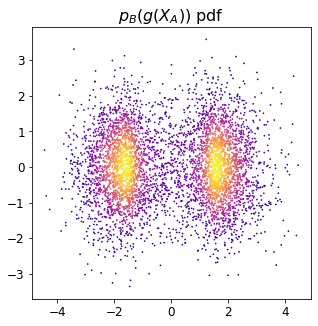

In [11]:
visualize_samples_pdf(X_B, p_B_X_B_autograd, r'$p_B(g(X_A))$ pdf')

### Computation of $det J_g$. Utilize structure of $g_{\theta}$

$x \in \mathbb{R}^D$

$g(x) = x + \mathbf{u}h(\mathbf{w}^T x + b)$


$\theta = \{\mathbf{u,w} \in \mathbb{R}^D, b \in \mathbb{R}\}$

$\left.\dfrac{\partial g(x, \theta)}{\partial x}\right|_{x = x} =  \mathbf{I} + \mathbf{u}h'(\mathbf{w}^T x + b)\mathbf{w}^T$

**Question** How to compute $\det \left(\dfrac{\partial g(x, \theta)}{\partial x}\Big{|}_{x = x}\right)$?

#### Matrix detminant lemma

Let $\mathbf{A} \in \mathbb{R}^{D \times D}$ is an invertable matrix. $\mathbf{V}, \mathbf{W} \in \mathbb{R}^{D \times M}$. Then:

$$
\det\left(\mathbf{A} + \mathbf{V} \mathbf{W}^T\right) = \det\left(\mathbf{A}\right) \det \left( \mathbf{I}_{M} + \mathbf{W}^T \mathbf{A}^{-1} \mathbf{V}\right)
$$

**Question** What is $M$ in our case? How to compute the $\det$ using matrix determinant lemma?

$\det \left(\dfrac{\partial g(x, \theta)}{\partial x}\Big{|}_{x = x}\right) = \left(1 + h'(\mathbf{w}^T x + b)\mathbf{w}^T\mathbf{I}^{-1}\mathbf{u} \right) \det(\mathbf{I}) = 1 + h'(\mathbf{w}^T x + b)\mathbf{w}^T \mathbf{u}$

**Question** Let $h'(x)$ is bounded, i.e. $\vert h'(x) \vert \leq L$. When $g(x) = x + \mathbf{u}h(\mathbf{w}^T x + b)$ is reversible?

$\mathbf{w}^T\mathbf{u} > -\frac{1}{L}$

In particular, if $h = \tanh$, $\mathbf{w}^T\mathbf{u} > -1$

In [8]:
def h_grad(x):
    return 1./torch.cosh(x).pow(2)

def batch_det_jacobian_analytic(x):
    adj = h_grad(x @ w + b)
    return 1. + adj * (w @ u)

det_gjacs_X_A_analytic = batch_det_jacobian_analytic(X_A)
log_det_gjacs_X_A_analytic = torch.log(det_gjacs_X_A_analytic)

p_B_X_B_analytic = torch.exp(p_A.log_prob(X_A).sum(-1) - log_det_gjacs_X_A_analytic)

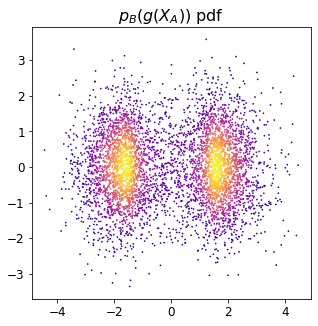

In [13]:
visualize_samples_pdf(X_B, p_B_X_B_analytic, r'$p_B(g(X_A))$ pdf')

In [10]:
torch.allclose(p_B_X_B_analytic, p_B_X_B_autograd)

True

**Conclusion**

Popular recipe to create normalizing flow:

* Come up with $g : A \rightarrow B$ with easy-to-compute $\det J_g$

* Make sure $\det J_g$ is nondegenerate

<center><img src="pics/flowsg.png" width=800 /></center>

**Question**

Let we model inverse transform $f: B \rightarrow A$, $f = g^{-1}$ via Planar Flow:

$f(x) = x + \mathbf{u}h(\mathbf{w}^T x + b)$

Let $x_B \in \mathbb{R}^D$. As usual, we suppose $p_A$ is known and $p_B$ is unknown. How to estimate $p_B(x_B)$?

$$
    p_B(x_B) = p_A(f(x_B)) \left\vert \det \left(\frac{\partial f(x, \theta)}{\partial x}\Big{|}_{x = x_B} \right) \right\vert
$$

Can we sample from $p_B$ in this case?

We need to know $x_B = g(x_A) = f^{-1}(x_A)$! <span style="color:red"> In general, unsolvable </span>

**Conclusion**

<center><img src="pics/flowsg.png" width=800 /></center>

Let we know the distribution $p_A$ (we could sample from it and estimate pdf). $p_B = g \sharp p_A$ 

| function we model   | sampling from $p_B$  | pdf estimation of $p_B$  |
|---|---|---|
| $$g : A \rightarrow B$$   |  $$X_A \sim p_A$$ $$X_B = g(X_A)$$   | <span style="color:red"> In general, unsolvable </span>  |
| $$f: B \rightarrow A$$  | <span style="color:red"> In general, unsolvable </span>  | $$
    p_B(x_B) = p_A(f(x_B)) \left\vert \det \left(\frac{\partial f(x, \theta)}{\partial x}\Big{|}_{x = x_B} \right) \right\vert
$$  |

## Normalizing flows

<center><img src="pics/flows_how2.png" width=800 /></center>

* $A = Z$ is the **latent space** where we know everything: we can **sample** $z \sim p_Z$ and **estimate pdf** $p_Z(z)$

* $B = X$ is the **data space** where we don't know something. Examples:

    * We have samples $X_1, \dots , X_N \sim \pi(x)$. $\pi(x)$ is unknown. **("partial" generative modeling framework)**
  
         - <span style="color:orange">We would like to estimate pdf of $\pi(x)$</span>
    
    * We know (unnormalized) pdf of $\pi(x)$. **(bayesian inference framework)**
    
        - <span style="color:orange">We would like to sample from $\pi(x)$</span>

**Question** How to solve the aforementioned tasks?

## Forward KL and Reverse KL

Let $p(x|\theta)$ is a distribution we model via normalizing flow: $g_{\theta} : Z \rightarrow X$ **or** $f_{\theta} : X \rightarrow Z$.

### Forward KL

<img src="pics/forwardkl.png" width=800 height=800 />

**Question** Which problem we can solve by minimizing $KL(\pi|| p)$? Do we utilize $g_{\theta}: Z \rightarrow X$ or $f_{\theta}: X \rightarrow Z$?

<img src="pics/forward_for_flow.png" width=800 height=800 />

* $KL(\pi || p)$ is estimated by MC using samples $X_1, \dots X_N \sim \pi(x)$

* We model $f_{\theta} : X \rightarrow Z$

### Reverse KL

<img src="pics/reversekl.png" width=800 height=800 />

**Question** Which problem we can solve by minimizing $KL(p|| \pi)$? Do we utilize $g_{\theta}: Z \rightarrow X$ or $f_{\theta}: X \rightarrow Z$?

<img src="pics/reverse_for_flow.png" width=800 height=800 />

* $KL(p || \pi)$ is estimated by MC since we could sample from $p_z(z)$ and know (unnormalized) $\pi(x)$

* We model $g_{\theta} : Z \rightarrow X$

**Question**

Does it make sense to optimize in $Z$-space? I.e. $KL(p(z) || p(z | \theta))$ and $KL(p(z | \theta) || p(z))$

### KL duality theorem

$$\arg\min\limits_{\theta} KL(\pi(x) || p(x|\theta)) = \arg\min\limits_{\theta} KL(p(z|\theta) || p(z))$$

$$\arg\min\limits_{\theta} KL(p(x || \theta), \pi(x)) = \arg\min\limits_{\theta} KL(p(z) || p(z|\theta))$$

**Conclusion.**

| what you know about $\pi(x)$  | problem you want to solve  | KL-divergence you use  | flow you model  | Objective  |
|---|---|---|---|---|
| Samples $X_1, \dots X_N$  | pdf estimation $\pi(x)$  | $$\text{Forward }KL(\pi(x) || p_{x}(x | \theta))\, , \,X \text{-space}$$  | $f_{\theta}: X \rightarrow Z$  | $$-E_{\pi(x)} \left(\log p_z(f(x, \theta)) +\\+ \log | \det J_f|\right)$$ |
| (unnormalized) pdf $\hat{\pi}(x)$  | sample from $\pi(x)$  |  $$\text{Reverse }KL(p_{x}(x | \theta) || \pi(x))\, , \,X \text{-space}$$ | $g_{\theta}: Z \rightarrow X$  | $$- E_{p(z)} \left( \log | \det J_g | +\\+ \log \pi(g(z, \theta))\right)$$  |
| Samples $X_1, \dots X_N$  |  pdf estimation $\pi(x)$ | $$\text{Reverse } KL(p_z(z|\theta) || p(z))\, , \,Z \text{-space}$$  | $f_{\theta} : X \rightarrow Z$  | $$- E_{\pi(x)} \left( \log | \det J_f | +\\+ \log p_z(f(x, \theta))\right)$$  |
| (unnormalized) pdf $\hat{\pi}(x)$ | sample from $\pi(x)$  | $$\text{Forward }KL(p(z) || p_{z}(z|\theta))\, , \,Z \text{-space}$$  | $$g_{\theta} : Z \rightarrow X$$   |  $$-E_{p_z(z)} \left(\log \pi(g(z, \theta)) +\\+ \log | \det J_g|\right)$$ |

## Training Planar flows